# Сборный проект по теме "Событийная аналитика"

## Введение

Цель проекта анализ результатов А/А/В теста в мобильном приложении.  

В А/В тесте исследовалось влияние изменений интерфейса (новые шрифты) на поведение пользователей. Пользователи были разбиты на три группы: две контрольные со старыми шрифтами для А/А теста, и экспериментальная с измененными шрифтами. Требуется определить изменилась ли конверсия наступлений тех или иных событий вслед за изменением шрифтов приложения.
В качестве данных у нас логи событий/действий пользователей. 

Сначала проведем предобработку данных, далее посчитаем конверсию наступления событий по группам, и потом проверим статистические гипотезы о равенстве долей.

## Импорты библиотек и загрузка данных

In [1]:
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 2.6 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("rocket")
from scipy import stats as st
import math as mth

In [3]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

## Знакомство с данными и подготовка

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В нашем распоряжении лог событий на сайте. Каждая запись — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [5]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# для удобства переименовываем столбцы
df.columns = ['event_name', 'device_id', 'timestamp', 'expld']

In [7]:
# переводим unix-время в формат datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s')

In [8]:
# проверим наличие дубликатов
df.duplicated().sum()

413

In [9]:
# удалим дубликаты 
df = df.drop_duplicates().reset_index(drop=True)

Данные чистые, пропуски отсутствуют. Есть незначительное количество дубликатов их мы удалили.

## Изучение и проверка данных

### Количество событий

In [10]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего в логе пять типов событий:
- отображение главного экрана
- отображение страницы с предложением (витрины) 
- отображение корзины
- сообщение об успешно проведенном платеже
- обращение к справке (разделу с обучением)

Первые четыре события выстраиваются в логичную воронку действий. 

In [11]:
print(f"Всего зафиксировано {df['event_name'].value_counts().sum()} событий разных типов.") 

Всего зафиксировано 243713 событий разных типов.


### Количество пользователей

Посчитаем сколько вссего уникальных пользователей во всех группах.

In [12]:
users_cnt = len(df['device_id'].unique())
users_cnt

7551

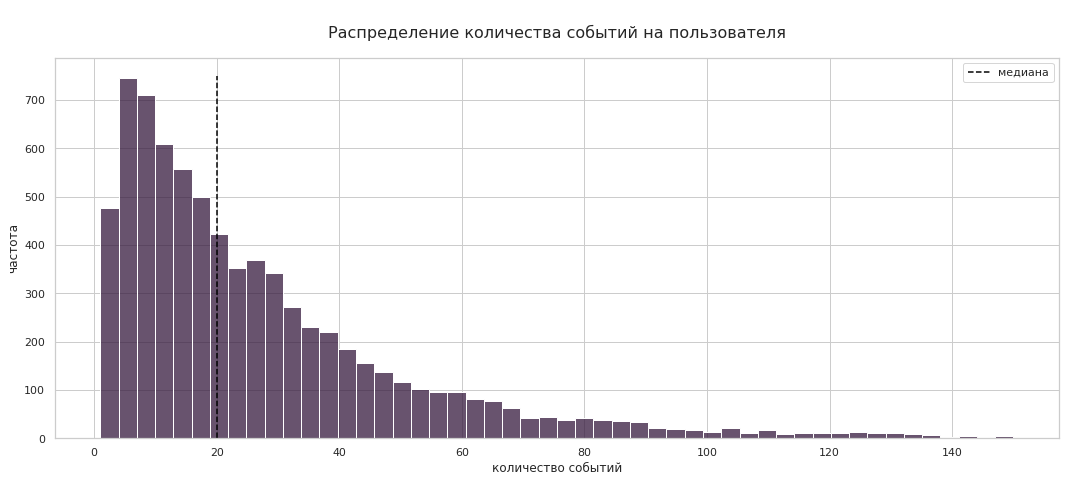

In [13]:
to_plot = df.groupby('device_id').count().reset_index()
u_e_median = to_plot['timestamp'].median()
fig, ax = plt.subplots(figsize=(18, 7))
ax = sns.histplot(to_plot.query('timestamp <= 150'), x="timestamp", bins=50)
ax.set_title('\nРаспределение количества событий на пользователя', fontsize=16, pad=20)
ax.set(ylabel='частота', xlabel='количество событий')
plt.plot( [u_e_median, u_e_median], [0, 750], linestyle='--', color='black', label = 'медиана')
ax.legend();

In [14]:
print(f"В среднем на пользователя приходится {round(len(df)/len(df['device_id'].unique()))} события")
print(f"Мода: {int(to_plot['timestamp'].mode())}")
print(f"Медиана: {to_plot['timestamp'].median()}")

В среднем на пользователя приходится 32 события
Мода: 5
Медиана: 20.0


Распределение ненормальное и имеет выраженный хвост вправо, в сторону максимальных значений. Чаще всего встречаются пользователи с небольшим количеством событий. Половину от всего количества пользователей, составляют имеющие менее 20 событий. 

### Период 

Посмотрим за какой период у нас данные.

In [15]:
print(f"Минимальная дата {str(df['datetime'].min())}")
print(f"Максимальная дата {str(df['datetime'].max())}")

Минимальная дата 2019-07-25 04:43:36
Максимальная дата 2019-08-07 21:15:17


Данные представлены за 14 дней эксперимента. Посмотрим как логи распределены по дням

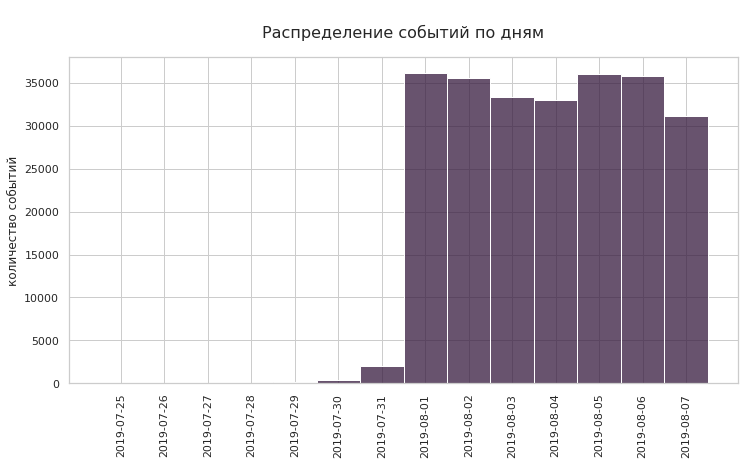

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(data=df['datetime'].dt.strftime('%Y-%m-%d'), bins=30)
ax.set_title('\nРаспределение событий по дням', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='')
plt.xticks(rotation=90);

Посмотрим внимательнее на время начала теста, "приблизим" период с с 30 июля по 2 августа

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


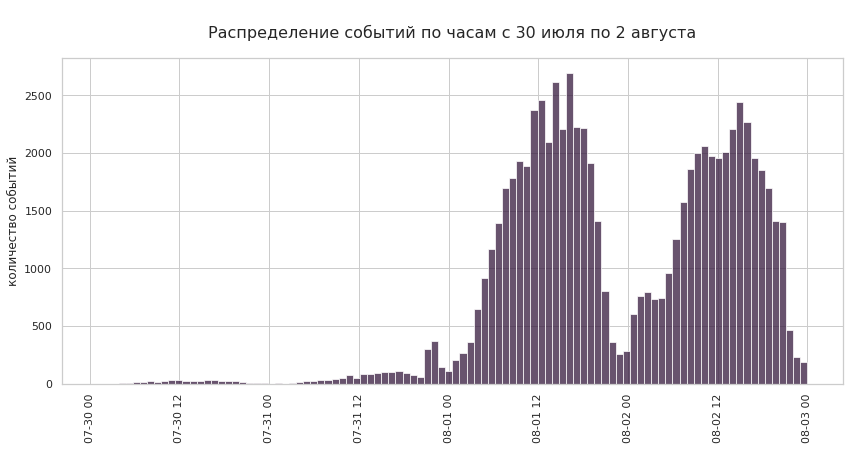

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.histplot(data=df[(df['datetime'] < '2019-08-03') & (df['datetime'] > '2019-07-30') ]['datetime'], bins=100)
ax.set_title('\nРаспределение событий по часам с 30 июля по 2 августа', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='')
plt.xticks(rotation=90);

Видно как суточные колебания резко меняют амплитуду, вечером 31 августа происходит резкий рост.

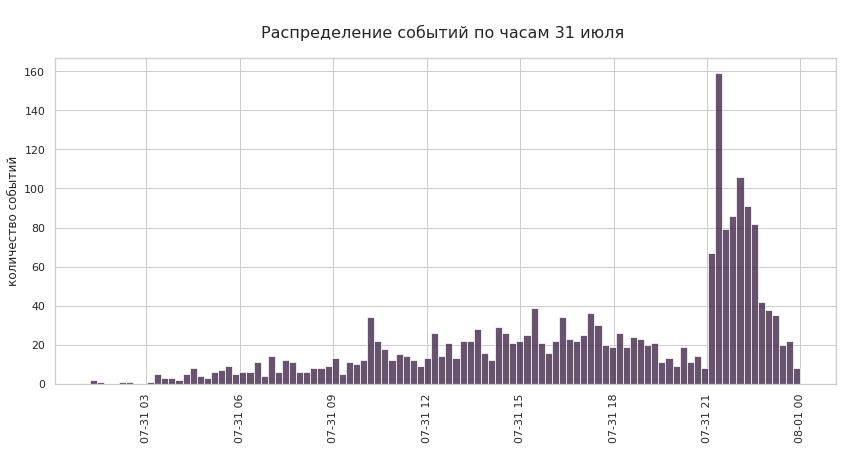

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.histplot(data=df[(df['datetime'] < '2019-08-01') & (df['datetime'] > '2019-07-31') ]['datetime'], bins=100)
ax.set_title('\nРаспределение событий по часам 31 июля ' , fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='')
plt.xticks(rotation=90);

Тест заработал в полную силу в 21:00.

По какой-то причине логи за первую неделю эксперимента практически отсутствуют. Что бы быть уверенным в полноте данных, ограничимся только второй неделей эксперимента.

In [19]:
# количество событий до 1 августа
len(df.loc[df['datetime'] <= '2019-07-31 21-00'])

1989

In [20]:
df = df.loc[df['datetime'] > '2019-07-31 21-00']

In [21]:
# разница между начальным количеством пользователей и количеством после удаления логов первой недели
users_cnt - len(df['device_id'].unique())

13

Удалив 1989 событий, мы потеряли 13 пользователей.

Посмотрим вновь на распределение, заодно изучим, как меняется количество разных событий.

In [22]:
df['day'] = df['datetime'].dt.strftime('%m-%d')

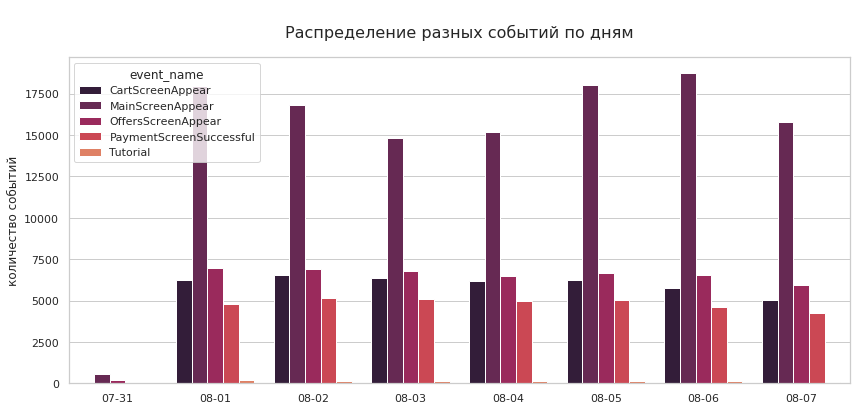

In [23]:
to_plot = df.groupby(['day', 'event_name']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=to_plot, x='day', y='device_id', hue='event_name')
ax.set_title('\nРаспределение разных событий по дням', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='');

В оставшиеся семь дней количесство событий разных типов более менее одинаково, аномалий нет.

Удостоверимся, что мы располагаем действиями пользователей всех групп эксперимента.

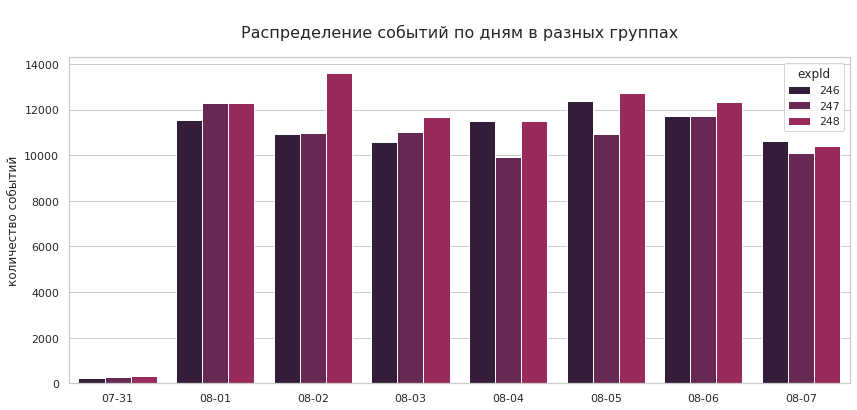

In [24]:
to_plot = df.groupby(['day', 'expld']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=to_plot, x='day', y='device_id', hue='expld')
ax.set_title('\nРаспределение событий по дням в разных группах', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='');

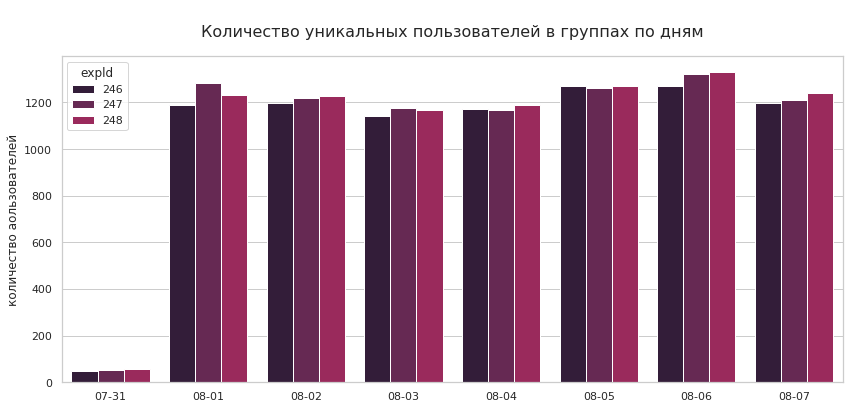

In [25]:
to_plot = df.pivot_table(index='day', columns='expld', values='device_id', aggfunc=pd.Series.nunique).unstack().reset_index()
to_plot.columns = ['expld', 'day', 'users']
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=to_plot, x='day', y='users', hue='expld')
ax.set_title('\nКоличество уникальных пользователей в группах по дням', fontsize=16, pad=20)
ax.set(ylabel='количество аользователей', xlabel='');

За исключением того что эксперимент по факту шел половину из двух недель, других аномалий не обнаружено. Количество пользователей в группах одинаковое, всплесков активности нет.

## Воронка событий

Предположим, что событиям логично происходить по порядку:
сначала главный экран, потом витрина, далее коризина и в конце оплата. 
Обращение к справке может происходить на любом этапе.
Для простоты пометим события буквами А, B, C, D по порядку.

In [26]:
event_dict = {
     
    'MainScreenAppear': 'A', 
    'OffersScreenAppear': 'B',
    'CartScreenAppear': 'C', 
    'PaymentScreenSuccessful': 'D',
    'Tutorial': 'Tutorial'
}

df['event_tag'] = df['event_name'].apply(lambda x: event_dict[x])

Нас интересует конверсия цепочки событий  A → B → C → D. По этому исключим события пользователей, которых хотя бы раз нет в первом событии А.

In [27]:
a_users = list(df.query("event_tag == 'A'")['device_id'])
# len(df.query('device_id in @a_user')['device_id'].unique())
# a_user

Есть пользователи которые за семь дней сделали аномально много действий. 

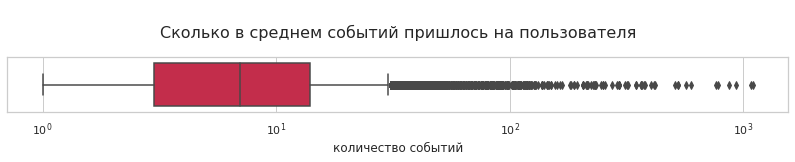

In [28]:
to_plot = df.groupby(['device_id', 'event_tag']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 1))
ax = sns.boxplot(x="timestamp", data=to_plot, color='crimson')
ax.set_xscale("log")
ax.set_title('\nСколько в среднем событий пришлось на пользователя', fontsize=16, pad=20)
ax.set(ylabel='', xlabel='количество событий');

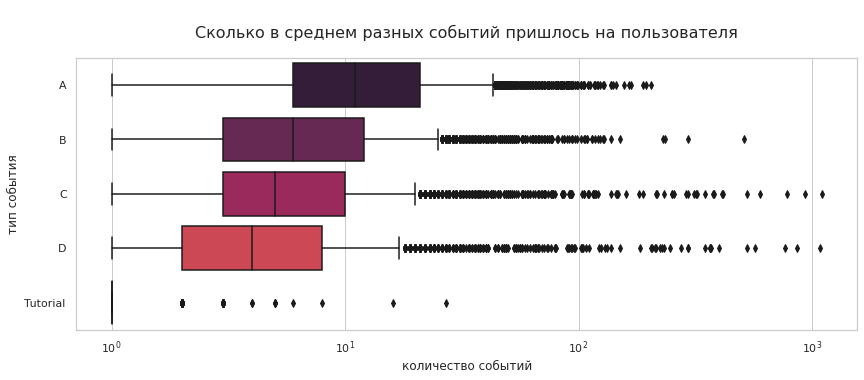

In [29]:
fig, ax = plt.subplots(figsize=(14, 5))
ax = sns.boxplot(y="event_tag", x= 'timestamp', data=to_plot)
# ax.xaxis.grid([1,2,5])
ax.set_xscale("log")
ax.set_title('\nСколько в среднем разных событий пришлось на пользователя', fontsize=16, pad=20)
ax.set(ylabel='тип события', xlabel='количество событий');

Средний пользователь за период сделал три заказа, то есть прошел всю цепь событий от A до D полностью три раза. Но есть и более активные пользователи. Посмотрим не будет ли их активность вносить искажение в результаты теста. Для начала определим границу, например в 150 событий (свыше 150 событий в неделю для пользователя будем считать выбросами). 


In [30]:
active_users = df.groupby('device_id')['event_tag'].count().reset_index()
active_users = list(active_users.query('150 < event_tag')['device_id'])

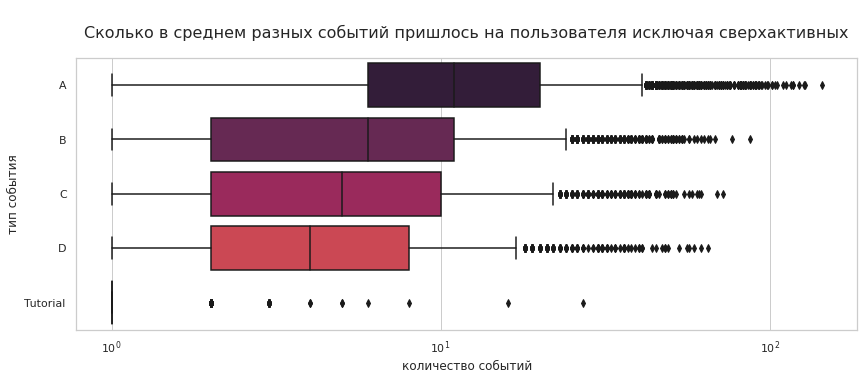

In [31]:
to_plot = df.query('device_id not in @active_users').groupby(['device_id', 'event_tag']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 5))
ax = sns.boxplot(y="event_tag", x= 'timestamp', data=to_plot)
# ax.xaxis.grid([1,2,5])
ax.set_xscale("log")
ax.set_title('\nСколько в среднем разных событий пришлось на пользователя исключая сверхактивных', fontsize=16, pad=20)
ax.set(ylabel='тип события', xlabel='количество событий');

In [32]:
print(f"Общее количество выделенныз таким образом сверхактивных пользователей: {len(active_users)}")

Общее количество выделенныз таким образом сверхактивных пользователей: 133


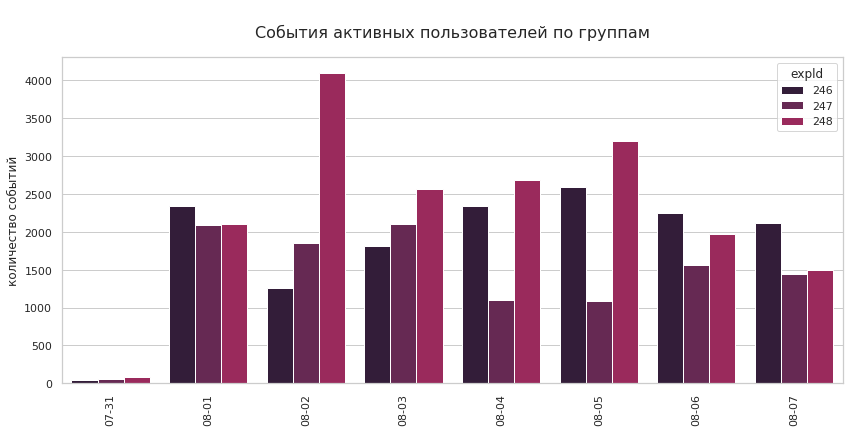

In [33]:
to_plot = df.query('device_id in @active_users').groupby(['day', 'expld']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=to_plot, x='day', y='device_id', hue='expld')
ax.set_title('\nСобытия активных пользователей по группам', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='')
plt.xticks(rotation=90);

Сверхактивные пользователи попадают в разные группы и вносят небольшой дисбаланс.

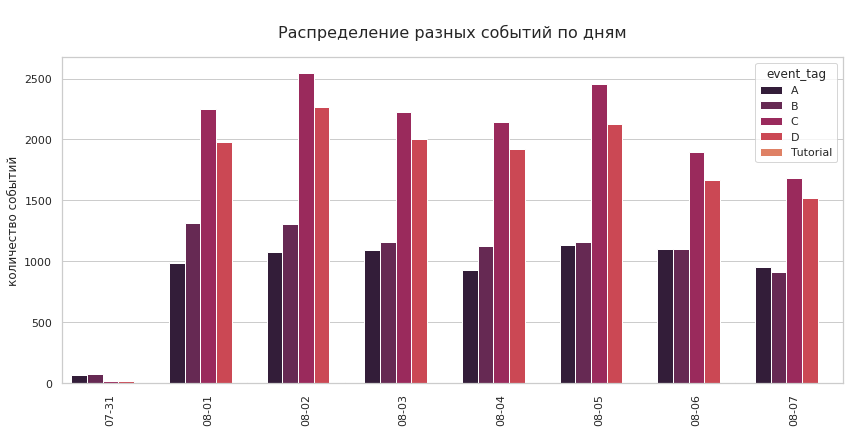

In [34]:
to_plot = df.query('device_id in @active_users').groupby(['day', 'event_tag']).count().reset_index()
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.barplot(data=to_plot, x='day', y='device_id', hue='event_tag')
ax.set_title('\nРаспределение разных событий по дням', fontsize=16, pad=20)
ax.set(ylabel='количество событий', xlabel='')
plt.xticks(rotation=90);

Сверхактивные пользователи часто начинают сразу с корзины и успешно завершают оплату.  Удалим действия сверхактивных пользователей, и пользователей у которых нет хотя бы одного события "А".

In [35]:
df = df.query('device_id not in @active_users and device_id in @a_users').copy()

In [36]:
print(f"Таким образом мы пожертвовали еще {users_cnt - len(df['device_id'].unique())}-ю пользователями.") 
n_users_cnt = len(df['device_id'].unique()) 

Таким образом мы пожертвовали еще 259-ю пользователями.


Сформируем воронку событий, посчитаем общее количество разных событий, и количество событий для уникальных пользователей. Отсортируем по предложенной выше логике.

In [37]:
events = df.groupby('event_tag').agg({'device_id': pd.Series.nunique, 'datetime': 'count'}).reset_index()
events.columns = ['event_tag', 'unique_users', 'event_cnt']
events

,event_tag,unique_users,event_cnt
0,A,7292,110549
1,B,4357,37514
2,C,3508,26367
3,D,3315,19852
4,Tutorial,810,965


Посчитаем воронку сразу для разных экспериментальных групп

In [38]:
events = df.pivot_table(index='event_tag', columns='expld', aggfunc=pd.Series.nunique, values='device_id')
events['total'] = events.sum(axis=1)
events

expld,246,247,248,total
event_tag,,,,
A,2407,2444,2441,7292
B,1467,1452,1438,4357
C,1194,1172,1142,3508
D,1128,1093,1094,3315
Tutorial,264,276,270,810


In [39]:
rate_events = events.copy()
previous_row_idx = 0

for index in range(len(rate_events)):
    rate_events.iloc[index] = events.iloc[index] / events.iloc[previous_row_idx]
    previous_row_idx = index

rate_events = rate_events.drop('Tutorial')


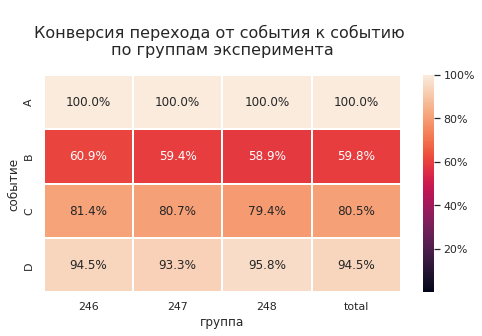

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.heatmap(rate_events, annot = True, fmt='.1%',                    
    vmin=.0, vmax=1, linewidths=1, linecolor='white')
cbar = ax.collections[0].colorbar
cbar.set_ticks([ .2, .4, .6, .8, 1])
cbar.set_ticklabels(['20%', '40%', '60%', '80%', '100%'])
ax.set_title('\nКонверсия перехода от события к событию \nпо группам эксперимента', fontsize=16, pad=20)
ax.set(ylabel='событие', xlabel='группа');

Основные потери происходят в процессе перехода с главного экрана на экран витрины, на первый взгляд поведение пользователей не отличается.

In [41]:
print(f"Общая конверсия: {events['total']['D'] / events['total']['A'] :.1%}")

Общая конверсия: 45.5%


Мы выявили и на всякий случай удалили события пользователей совершивших более 150 действий, хотя возможно и переоценили степень их влияния. 

Расположили события в порядке их вероятного наступления, отбросив событие "обращение к обучающему разделу" и посчитали конверсию перехода от события к событию.
Самая низкая конверсия и самые большие потери пользователей - при переходе от события "А" к событию "В" - примерно 60%. (Возможно не каждый раз когда пользователь заходит в приложение, его цель совершить заказ. Можно предположить что он смотрит статус заказа или проверяет, где курьер).

От первого события до оплаты в среднем доходит 45% пользователей.

## Проверка гипотез

In [42]:
# доработаем сводную таблицу для проверки гипотез
events = events.drop('Tutorial').reset_index()
events.columns = ['event_tag', '246', '247', '248', 'total']
events['246+247'] = events['246'] + events['247']


Проверим есть ли различия в конверсиях контрольных групп 246 и 247. 

In [43]:
def compare(event_tag, first_group, second_group, alpha):
    """Принимает тэг события, номера экспериментальных групп из таблицы 'events' 
       и значение уровня статистической значимости 'alpha'
       Проверяет гипотезу на равенство долей (конверсию наступления выбранного события)"""
    first_group_successes = events[events['event_tag'] == event_tag][first_group]
    second_group_successes = events[events['event_tag'] == event_tag][second_group]
    first_group_trials = events.shift()[events['event_tag'] == event_tag][first_group]
    second_group_trials = events.shift()[events['event_tag'] == event_tag][second_group]
        # пропорция успехов в первой группе:
    p1 = first_group_successes/first_group_trials
        # пропорция успехов во второй группе:
    p2 = second_group_successes/second_group_trials
        # пропорция успехов в комбинированном датасете:
    p_combined = (first_group_successes + second_group_successes) / (first_group_trials + second_group_trials)
        # разница пропорций в датасетах
    difference = p1 - p2  
        # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / first_group_trials + 1 / second_group_trials)
        )
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f"Нулевая гипотеза: конверсия наступления события {event_tag} в группах {first_group} и {second_group}  - одинакова.")
    print(f"Альтернативная гипотеза: конверсия события {event_tag} в группах {first_group} и {second_group} - различается.")
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: конверсии отличчаются')
    else:
        print('Нет оснований отвергать нулевую гипотезу') 
    print('----------------------------------------')


Что бы снизить групповую вероятность ошибки первого рода (ложного отклонения нулевой гипотезы) сразу применим поправку Бонферрони. 

In [44]:
# делим стандартное значение на общее количество сравнений
alpha = 0.05 / 12

In [45]:
print('Сравниваем контрольные группы 246 и 247: \n----------------------------------------')
compare('B', '246', '247', alpha)
compare('C', '246', '247', alpha)
compare('D', '246', '247', alpha)

Сравниваем контрольные группы 246 и 247: 
----------------------------------------
Нулевая гипотеза: конверсия наступления события B в группах 246 и 247  - одинакова.
Альтернативная гипотеза: конверсия события B в группах 246 и 247 - различается.
p-значение:  [0.27441835]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события C в группах 246 и 247  - одинакова.
Альтернативная гипотеза: конверсия события C в группах 246 и 247 - различается.
p-значение:  [0.64203021]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события D в группах 246 и 247  - одинакова.
Альтернативная гипотеза: конверсия события D в группах 246 и 247 - различается.
p-значение:  [0.21873719]
Нет оснований отвергать нулевую гипотезу
----------------------------------------


Нет оснований считать различающимся поведение пользователей из контрольных групп.

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 

In [46]:
print('Сравниваем группы 246 и 248: \n----------------------------------------')
compare('B', '246', '248', alpha)
compare('C', '246', '248', alpha)
compare('D', '246', '248', alpha)

Сравниваем группы 246 и 248: 
----------------------------------------
Нулевая гипотеза: конверсия наступления события B в группах 246 и 248  - одинакова.
Альтернативная гипотеза: конверсия события B в группах 246 и 248 - различается.
p-значение:  [0.14789078]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события C в группах 246 и 248  - одинакова.
Альтернативная гипотеза: конверсия события C в группах 246 и 248 - различается.
p-значение:  [0.17996491]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события D в группах 246 и 248  - одинакова.
Альтернативная гипотеза: конверсия события D в группах 246 и 248 - различается.
p-значение:  [0.1374822]
Нет оснований отвергать нулевую гипотезу
----------------------------------------


In [47]:
print('Сравниваем группы 247 и 248: \n----------------------------------------')
compare('B', '247', '248', alpha)
compare('C', '247', '248', alpha)
compare('D', '247', '248', alpha)

Сравниваем группы 247 и 248: 
----------------------------------------
Нулевая гипотеза: конверсия наступления события B в группах 247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события B в группах 247 и 248 - различается.
p-значение:  [0.72195275]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события C в группах 247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события C в группах 247 и 248 - различается.
p-значение:  [0.38158813]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события D в группах 247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события D в группах 247 и 248 - различается.
p-значение:  [0.00737348]
Нет оснований отвергать нулевую гипотезу
----------------------------------------


In [48]:
print('Сравниваем группу 248 и объединенную контрольную группу: \n----------------------------------------')
compare('B', '246+247', '248', alpha)
compare('C', '246+247', '248', alpha)
compare('D', '246+247', '248', alpha)

Сравниваем группу 248 и объединенную контрольную группу: 
----------------------------------------
Нулевая гипотеза: конверсия наступления события B в группах 246+247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события B в группах 246+247 и 248 - различается.
p-значение:  [0.29939368]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события C в группах 246+247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события C в группах 246+247 и 248 - различается.
p-значение:  [0.1989349]
Нет оснований отвергать нулевую гипотезу
----------------------------------------
Нулевая гипотеза: конверсия наступления события D в группах 246+247 и 248  - одинакова.
Альтернативная гипотеза: конверсия события D в группах 246+247 и 248 - различается.
p-значение:  [0.01910624]
Нет оснований отвергать нулевую гипотезу
----------------------------------------


## Вывод 

По какойто причине в логах отсутствуютданные за первую неделю эксперимента, по этому нам пришлось ограничиваться только данными за последние семь дней.
Среди пользователей есть крайне активные пользователи совершающие аномально много покупок, если это не результат тестирования, то их поведение и их самих нужно изучить отдельно. Действия этих пользователей были исключены из анализа, так как вносили бы дисбаланс.

Основные потери в конверсии происходят при переходе от главного экрана к "витрине", примерно 40% не идут дальше главной страницы. Общая конверсия от гравного экрана к успешной оплате составляет 45%.

Статистически значимых различий в поведении экспериментальных групп не обнаружено.
Менеджеры беспокоились напрасно: изменение шрифтов в приложении не влечет за собой  изменений в поведении пользователей.